In [179]:
!pip install pandas numpy yfinance statsmodels scikit-learn keras matplotlib alpha-vantage vaderSentiment

In [180]:
# **************** IMPORT PACKAGES ********************
import yfinance as yf
import requests
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from alpha_vantage.timeseries import TimeSeries
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA

In [181]:
def download_stock_data(ticker):
    """Downloads historical stock data from Yahoo Finance and saves it to a CSV file.

    Args:
        ticker: The stock ticker symbol (e.g., 'AAPL').
    """
    try:
        # Download data using yfinance
        end = datetime.now()
        start = datetime(end.year - 2, end.month, end.day)
        data = yf.download(ticker, start=start, end=end)
        # Save data to CSV file
        data.to_csv(f'{ticker}.csv')
        print(f"\nData for {ticker} downloaded and saved to {ticker}.csv")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Example usage
ticker = "HDFCBANK.NS"  # Replace with your desired ticker symbol

download_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed


Data for HDFCBANK.NS downloaded and saved to HDFCBANK.NS.csv


In [182]:
df=pd.read_csv("HDFCBANK.NS.csv")

In [183]:
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-15 00:00:00+00:00,1579.0809326171875,1619.0,1623.1500244140625,1605.25,1623.1500244140625,5515101
3,2022-11-16 00:00:00+00:00,1592.6383056640625,1632.9000244140625,1642.0,1612.0,1618.6500244140625,6789075
4,2022-11-17 00:00:00+00:00,1578.251953125,1618.1500244140625,1631.550048828125,1613.9000244140625,1618.0999755859375,6050465


In [184]:
df.columns=["Date","Adj Close","Close","High","Low","Open","volume"]

In [185]:
df.drop(0,axis=0,inplace=True)
df.drop(1,axis=0,inplace=True)

In [186]:
df.head()

,Date,Adj Close,Close,High,Low,Open,volume
2,2022-11-15 00:00:00+00:00,1579.0809326171875,1619.0,1623.1500244140625,1605.25,1623.1500244140625,5515101
3,2022-11-16 00:00:00+00:00,1592.6383056640625,1632.9000244140625,1642.0,1612.0,1618.6500244140625,6789075
4,2022-11-17 00:00:00+00:00,1578.251953125,1618.1500244140625,1631.550048828125,1613.9000244140625,1618.0999755859375,6050465
5,2022-11-18 00:00:00+00:00,1574.1068115234375,1613.9000244140625,1623.0,1605.25,1621.0,5229616
6,2022-11-21 00:00:00+00:00,1557.9647216796875,1597.3499755859375,1612.0,1590.199951171875,1607.6500244140625,4172408


In [187]:
df.tail()

,Date,Adj Close,Close,High,Low,Open,volume
492,2024-11-08 00:00:00+00:00,1754.449951171875,1754.449951171875,1761.800048828125,1745.8499755859375,1752.0,9951493
493,2024-11-11 00:00:00+00:00,1766.300048828125,1766.300048828125,1782.800048828125,1751.199951171875,1754.550048828125,12282681
494,2024-11-12 00:00:00+00:00,1718.199951171875,1718.199951171875,1775.0,1708.6500244140625,1772.0,15697703
495,2024-11-13 00:00:00+00:00,1681.3499755859375,1681.3499755859375,1729.4000244140625,1673.0,1716.75,17864250
496,2024-11-14 00:00:00+00:00,1692.75,1692.75,1704.8499755859375,1672.0999755859375,1673.0999755859375,13573235


In [188]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index("Date",inplace=True)

In [189]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [190]:
df.head()

,Adj Close,Close,High,Low,Open,volume
Date,,,,,,
2022-11-15,1579.080933,1619.000000,1623.150024,1605.250000,1623.150024,5515101
2022-11-16,1592.638306,1632.900024,1642.000000,1612.000000,1618.650024,6789075
2022-11-17,1578.251953,1618.150024,1631.550049,1613.900024,1618.099976,6050465
2022-11-18,1574.106812,1613.900024,1623.000000,1605.250000,1621.000000,5229616
2022-11-21,1557.964722,1597.349976,1612.000000,1590.199951,1607.650024,4172408


In [191]:
df.describe()

,Adj Close,Close,High,Low,Open,volume
count,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02
mean,1578.551987,1598.803033,1611.364745,1586.562829,1598.936161,1.769372e+07
std,86.639792,84.899651,85.340786,84.371730,85.549332,1.434126e+07
min,1365.404785,1384.050049,1391.500000,1363.550049,1376.000000,8.798460e+05
25%,1516.220337,1535.750000,1550.725037,1527.100037,1537.549988,1.069427e+07
50%,1590.346191,1616.599976,1631.849976,1605.000000,1618.599976,1.565220e+07
75%,1633.518555,1654.949951,1668.549988,1644.025024,1654.349976,2.091058e+07
max,1783.449951,1783.449951,1794.000000,1768.050049,1791.000000,2.226710e+08


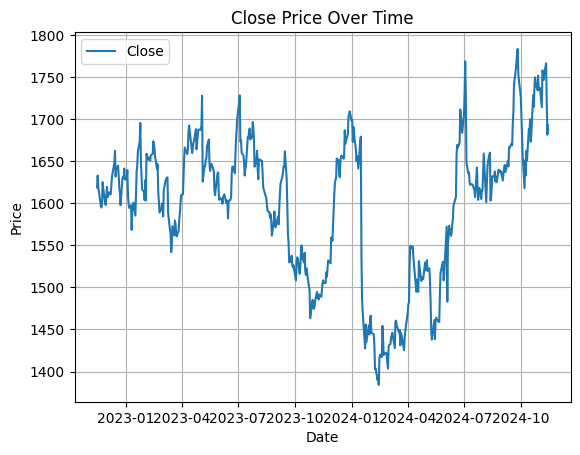

In [192]:
# Plot 'Close' against 'Date' (the index)
df['Close'].plot(kind='line')

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price Over Time")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

In [193]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Close'])

#H0 It is non stationary
#H1 H0 It is stationary

def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df['Close'])

ADF Test Statistic : -2.5124302637571536
p-value : 0.11247912687104594
#Lags Used : 0
Number of Observations Used : 494
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [194]:
df['close first Difference'] = df['Close']-df['Close'].shift(1)

In [195]:
df.head()

,Adj Close,Close,High,Low,Open,volume,close first Difference
Date,,,,,,,
2022-11-15,1579.080933,1619.000000,1623.150024,1605.250000,1623.150024,5515101,NaN
2022-11-16,1592.638306,1632.900024,1642.000000,1612.000000,1618.650024,6789075,13.900024
2022-11-17,1578.251953,1618.150024,1631.550049,1613.900024,1618.099976,6050465,-14.750000
2022-11-18,1574.106812,1613.900024,1623.000000,1605.250000,1621.000000,5229616,-4.250000
2022-11-21,1557.964722,1597.349976,1612.000000,1590.199951,1607.650024,4172408,-16.550049


In [196]:
adfuller_test(df['close first Difference'].dropna())

ADF Test Statistic : -22.34358549275532
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 493
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


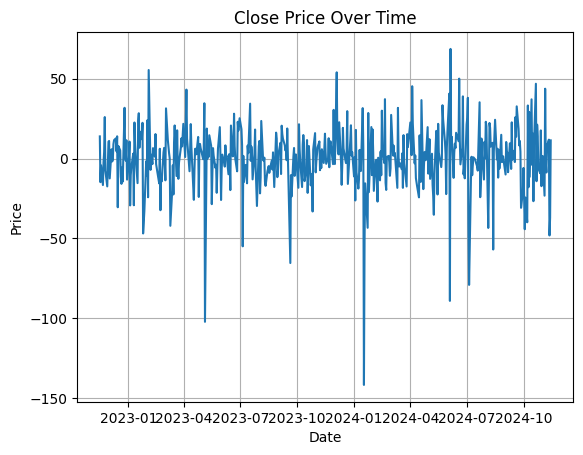

In [197]:
df['close first Difference'].plot(kind='line')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price Over Time")
plt.grid(True)

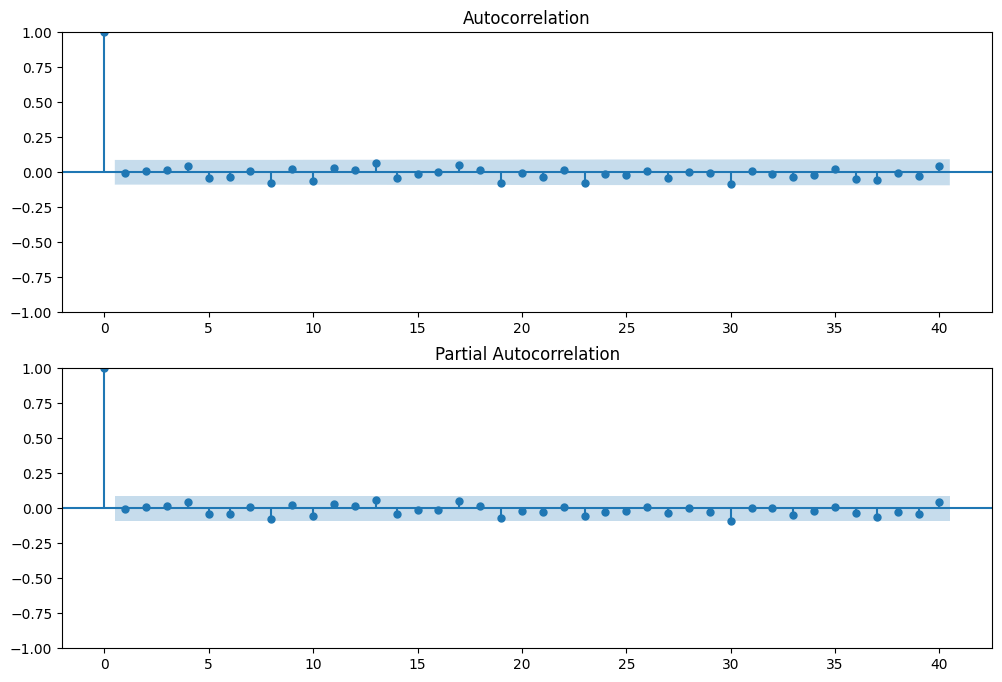

In [198]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 8))
# Use fig.add_subplot() instead of fig.add()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['close first Difference'].dropna(), lags=40, ax=ax1)
# Use fig.add_subplot() instead of fig.add()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['close first Difference'].dropna(), lags=40, ax=ax2)
plt.show() # Display the plot

In [199]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Close'],order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [200]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  495
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2179.457
Date:                Fri, 15 Nov 2024   AIC                           4364.915
Time:                        08:24:36   BIC                           4377.523
Sample:                             0   HQIC                          4369.865
                                - 495                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5183     44.936      0.012      0.991     -87.555      88.591
ma.L1         -0.5178     44.946     -0.012      0.991     -88.610      87.574
sigma2       397.7522     12.374     32.143      0.000     373.499     422.006
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1283.72
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -1.26
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

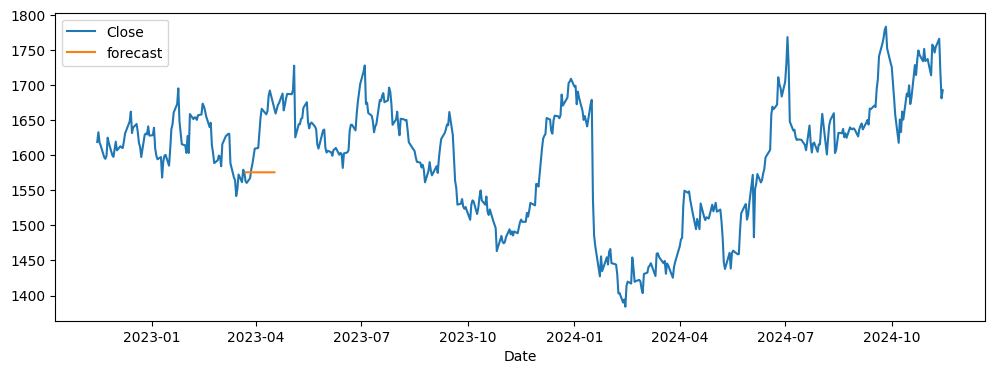

In [201]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Close','forecast']].plot(figsize=(12,4))

In [211]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Close'],order=(1,1,1),seasonal_order=(1,1,1,7))
results=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

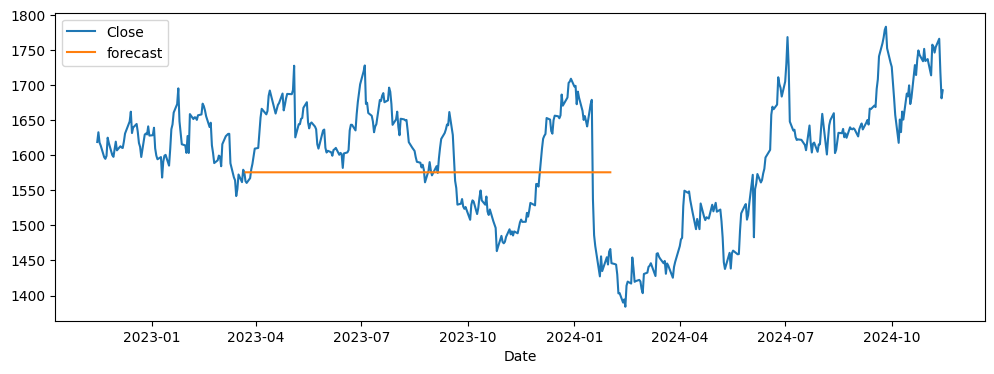

In [212]:
df['forecast']=model_fit.predict(start=90,end=300,dynamic=True)
df[['Close','forecast']].plot(figsize=(12,4))

In [215]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,30)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [ ]:
future_datest_df.tail()

In [ ]:
future_df=pd.concat([df,future_datest_df])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<Axes: >

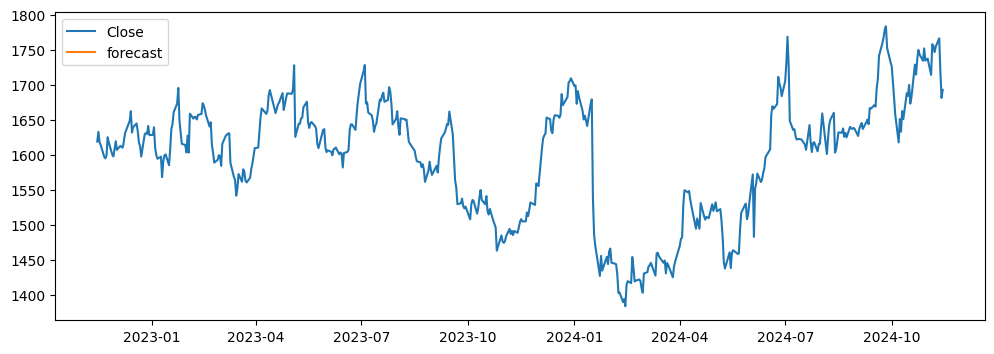

In [219]:
future_df['forecast']=results.predict(start=1500,end=1530,dynamic=True)
future_df[['Close','forecast']].plot(figsize=(12,4))

OM TRIAL

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from datetime import datetime, timedelta
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class StockPredictor:
    def __init__(self, ticker):
        self.ticker = ticker
        self.df = None
        self.model_fit = None
        self.future_predictions = None
        self.future_dates = None

    def download_data(self):
        """Download historical stock price data."""
        try:
            logger.info(f"Downloading data for {self.ticker}...")
            self.df = yf.download(self.ticker, start="2015-01-01", end=datetime.today().strftime('%Y-%m-%d'))
            if self.df.empty:
                logger.error("No data downloaded. Please check the ticker symbol.")
                return False
            self.df['Date'] = self.df.index
            logger.info(f"Data downloaded successfully for {self.ticker}.")
            return True
        except Exception as e:
            logger.error(f"Error downloading data: {str(e)}")
            return False

    def check_stationarity(self, series):
        """Perform Augmented Dickey-Fuller test to check stationarity."""
        result = adfuller(series.dropna())
        return result[1] <= 0.05  # Stationary if p-value <= 0.05

    def make_stationary(self):
        """Convert the series to a stationary one."""
        logger.info("Checking stationarity...")
        if not self.check_stationarity(self.df['Close']):
            logger.info("Data is non-stationary. Differencing to make it stationary.")
            self.df['Stationary_Close'] = self.df['Close'].diff().dropna()
        else:
            logger.info("Data is stationary. Proceeding without differencing.")
            self.df['Stationary_Close'] = self.df['Close']

    def plot_acf_pacf(self):
        """Visualize ACF and PACF to determine lag values."""
        plt.figure(figsize=(14, 7))

        plt.subplot(121)
        plot_acf(self.df['Stationary_Close'].dropna(), lags=20, ax=plt.gca())
        plt.title("ACF")

        plt.subplot(122)
        plot_pacf(self.df['Stationary_Close'].dropna(), lags=20, ax=plt.gca())
        plt.title("PACF")

        plt.tight_layout()
        plt.show()

    def select_arima_order(self):
        """Select the optimal ARIMA model order using auto_arima."""
        logger.info("Selecting optimal (p, d, q) values using auto_arima.")
        arima_model = auto_arima(
            self.df['Stationary_Close'].dropna(),
            seasonal=False,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            max_p=5,  # Limit p
            max_q=5,  # Limit q
            d=None  # Automatically determine differencing
        )
        return arima_model.order

    def train_and_predict(self, days=7):
        """Train ARIMA model and predict future stock prices."""
        try:
            # Prepare data
            self.make_stationary()

            # Select ARIMA order
            p, d, q = self.select_arima_order()
            logger.info(f"Optimal ARIMA order found: (p={p}, d={d}, q={q})")

            # Train ARIMA model
            model = ARIMA(self.df['Stationary_Close'], order=(p, d, q))
            self.model_fit = model.fit()

            # Generate future dates (business days only)
            last_date = self.df.index[-1]
            self.future_dates = pd.date_range(
                start=last_date + timedelta(days=1),
                periods=days,
                freq='B'
            )

            # Make predictions
            forecast = self.model_fit.forecast(steps=days)
            logger.info(f"Raw forecast values: {forecast}")

            # Restore to original scale if data was differenced
            if d > 0:
                last_value = self.df['Close'].iloc[-1]
                forecast = np.cumsum(forecast) + last_value
                logger.info(f"Forecast restored to original scale: {forecast}")

            # Store predictions
            self.future_predictions = pd.DataFrame(
                forecast,
                index=self.future_dates,
                columns=['Predicted']
            )

            logger.info("Model training and predictions completed successfully.")
            return True

        except Exception as e:
            logger.error(f"Error in training and prediction: {str(e)}")
            return False

def plot_predictions(self):
        """Plot actual and predicted stock prices."""
        plt.figure(figsize=(15, 7))

        # Plot actual prices
        plt.plot(self.df.index, self.df['Close'],
                 label='Actual Price',
                 color='blue',
                 linewidth=2)

        # Plot future predictions
        plt.plot(self.future_dates,
                 self.future_predictions['Predicted'],
                 label='Future Predictions',
                 color='red',
                 linestyle='--',
                 linewidth=2,
                 marker='o',
                 markersize=4)

        plt.title(f'{self.ticker} Stock Price Prediction', fontsize=14, pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best', fontsize=10)
        plt.xticks(rotation=45)

        # Add annotations for last prices
        # Get the last actual price as a single numeric value
        last_actual = self.df['Close'].iloc[-1].item()
        last_predicted = self.future_predictions['Predicted'].iloc[-1]

        plt.annotate(f'Last Actual: {last_actual:.2f}',
                     xy=(self.df.index[-1], last_actual),
                     xytext=(10, 10),
                     textcoords='offset points',
                     fontsize=10,
                     color='blue')

        plt.annotate(f'Last Predicted: {last_predicted:.2f}',
                     xy=(self.future_dates[-1], last_predicted),
                     xytext=(10, -10),
                     textcoords='offset points',
                     fontsize=10,
                     color='red')

        plt.tight_layout()
        plt.show()

        # Print future predictions
        logger.info("\nPredicted prices for next trading days:")
        predictions_df = self.future_predictions.copy()
        predictions_df['Date'] = predictions_df.index.strftime('%Y-%m-%d')
        predictions_df['Predicted'] = predictions_df['Predicted'].round(2)
        print(predictions_df[['Date', 'Predicted']].to_string(index=False))


def main():
    # Create predictor instance
    predictor = StockPredictor("HDFCBANK.NS")

    # Execute prediction pipeline
    if predictor.download_data():
        if predictor.train_and_predict(days=7):
            predictor.plot_predictions()


if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20804.493, Time=3.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20808.364, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=20807.521, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=20807.209, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=20805.383, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20804.872, Time=0.58 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.66 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=6.52 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20803.445, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=20803.891, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=20803.215, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=20804.395, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=20805.816, Time=0.75 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=20803.109, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] interce

AttributeError: 'StockPredictor' object has no attribute 'plot_predictions'

In [226]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
